**After Kaggle kernel: Analyze Power Line Signal Like a Physicist**

See vsb_analyze-power-line-signals_parallel.py for HF/LF signal division

In [30]:
import csv
import numpy as np
from numpy.fft import rfft, rfftfreq, irfft
from scipy.interpolate import interp1d
from scipy import fftpack, signal
from scipy.signal import butter, filtfilt, hilbert
from scipy.signal import sosfilt, sosfreqz
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import pickle
import re
import random

In [2]:
import datashader as ds
from datashader import transfer_functions as tf

In [3]:
period = 0.02
time_step = 0.02 / 800000.
time_vec = np.arange(0, 0.02, time_step)
f_sampling = 1 / time_step
print(f'Sampling Frequency = {f_sampling / 1e6} MHz')
# print (str(50* 800000 /1e6) + ' MHz')

Sampling Frequency = 40.0 MHz


Read signals (variable x). 
I would like to thank https://www.kaggle.com/xhlulu/exploring-signal-processing-with-scipy and the host: https://www.kaggle.com/sohier/reading-the-data-with-python

In [4]:
#xs = pq.read_table('../input/train.parquet', columns=[str(i) for i in range(999)]).to_pandas()
xs = pq.read_table('../input/train.parquet').to_pandas()
print((xs.shape))
xs.head(2)

(800000, 8712)


0  1   2   3  4   5   6   7  8   9  ...   8702  8703  8704  8705  8706  \
0  18  1 -19 -16 -5  19 -15  15 -1 -16  ...     18   -22    12     8    13   
1  18  0 -19 -17 -6  19 -17  16  0 -15  ...     17   -21    12     8    14   

   8707  8708  8709  8710  8711  
0     6   -21   -15    -9    20  
1     7   -19   -15    -8    21  

[2 rows x 8712 columns]

Read labels (variable y). 

In [5]:
train_meta = pd.read_csv('../input/metadata_train.csv')
print(train_meta.shape)
train_meta.head(6)
train_meta_good = train_meta[train_meta.target == 0]
train_meta_error = train_meta[train_meta.target == 1]
id_error = train_meta_error.groupby('id_measurement')['target'].count()
id_error.head(6)

(8712, 4)


id_measurement
1     3
67    2
76    3
90    3
93    3
95    3
Name: target, dtype: int64

In [96]:
train_meta.head()

signal_id  id_measurement  phase  target
0          0               0      0       0
1          1               0      1       0
2          2               0      2       0
3          3               1      0       1
4          4               1      1       1

In [51]:
three_phase_sigs=len(train_meta)/3
three_phase_sigs

2904.0

In [48]:
train_meta_good.head()

signal_id  id_measurement  phase  target
0          0               0      0       0
1          1               0      1       0
2          2               0      2       0
6          6               2      0       0
7          7               2      1       0

In [63]:
train_meta_error.head()

signal_id  id_measurement  phase  target
3            3               1      0       1
4            4               1      1       1
5            5               1      2       1
201        201              67      0       1
202        202              67      1       1

In [66]:
#get id_measurement of errors
train_error_idms=train_meta_error['id_measurement'].unique()

In [67]:
#get all phases even if only 1 has error
all_phase_error=train_meta.loc[train_meta['id_measurement'].isin(train_error_idms)]

In [68]:
train_meta_error_3_phase_0=all_phase_error.loc[all_phase_error['phase'] == 0]

In [70]:
train_meta_error_3_phase_0.head()

signal_id  id_measurement  phase  target
3            3               1      0       1
201        201              67      0       1
228        228              76      0       1
270        270              90      0       1
279        279              93      0       1

#### good

In [73]:
train_meta_error_3_phase_ids=train_meta_error_3_phase_0['id_measurement']

In [75]:
#get id_measurement of goods

all_idms=train_meta['id_measurement'].unique()

In [89]:
train_good_id_measurement = list(set(all_idms)-set(train_meta_error_3_phase_ids))

In [90]:
train_good_id_measurement[0]

0

#### bad

In [68]:
train_meta_error_3_phase_0=all_phase_error.loc[all_phase_error['phase'] == 0]

In [70]:
train_meta_error_3_phase_0.head()

signal_id  id_measurement  phase  target
3            3               1      0       1
201        201              67      0       1
228        228              76      0       1
270        270              90      0       1
279        279              93      0       1

In [86]:
train_meta_error_id_measurement=train_meta_error_3_phase_0['id_measurement']

In [87]:
train_meta_error_id_measurement=list(train_meta_error_id_measurement)

In [91]:
train_meta_error_id_measurement[1]

67

Examine how many phases with one ID were labelled problematic. For 80.4% faulty lines, three phases were all labelled faulty, while one-faulty-phase and two-faulty-phase lines contribute about 10% and 10%, respectively.  

3    156
2     19
1     19
Name: target, dtype: int64
3    0.804124
2    0.097938
1    0.097938
Name: target, dtype: float64


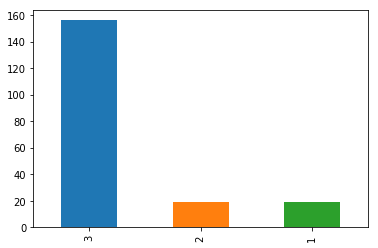

In [4]:
id_error_c = id_error.astype('category')
print(id_error_c.value_counts())
print(id_error_c.value_counts() / id_error_c.value_counts().sum())
id_error_c.value_counts().plot(kind='bar')

In [7]:
# Fetch one signal from xs
idx = 1
sig = xs.iloc[:, idx]
idx_error = 3
sig_error = xs.iloc[:, idx_error]
print(sig.shape)

(800000,)


[]

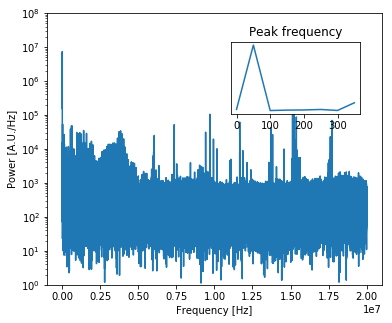

In [8]:
# https://www.scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html
# The FFT of the signal
sig_fft = fftpack.fft(sig)
# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)
# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq >= 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

plt.figure(figsize=(6, 5))
# plt.plot(sample_freq[pos_mask], power[pos_mask])
plt.semilogy(sample_freq[pos_mask], power[pos_mask])
plt.ylim([1e-0, 1e8])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [A.U./Hz]')


# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.6, 0.3, 0.2])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

The inset figure above shows that peak frequency is 50 Hz, as we expected. Note that the frequency step in fft spectrum is 50 Hz, limited by the total duration of the signal. 
Next we use a slightly different method (signal.periodogram) and plot the power spectrum in log-log scale, which make more sense. The unit in the y axis is different by a fixed factor. It is OK. 

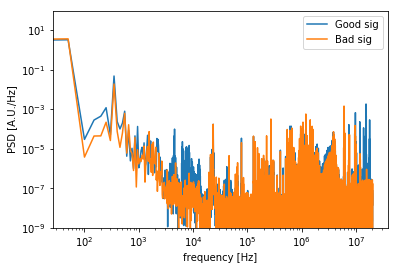

In [8]:
def plot_ps(sig, f_sampling, label='sig', style='loglog'):
    f, Pxx_den = signal.periodogram(sig, f_sampling)
    if style == 'semilogy':
        plt.semilogy(f, Pxx_den, label=label)
    else:
        plt.loglog(f, Pxx_den, label=label)
    plt.ylim([1e-9, 1e2])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [A.U./Hz]')
    
plot_ps(sig, f_sampling, 'Good sig')
plot_ps(sig_error, f_sampling, 'Bad sig')
plt.legend(loc='best')
plt.show()
# The horizontal line at 50 Hz is artificial, as the log scale in the x axis cannot show 0 Hz. 

20000000.0, 0.0, 3.327244997024536, 2.3160366628198205e-33


/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:1441: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


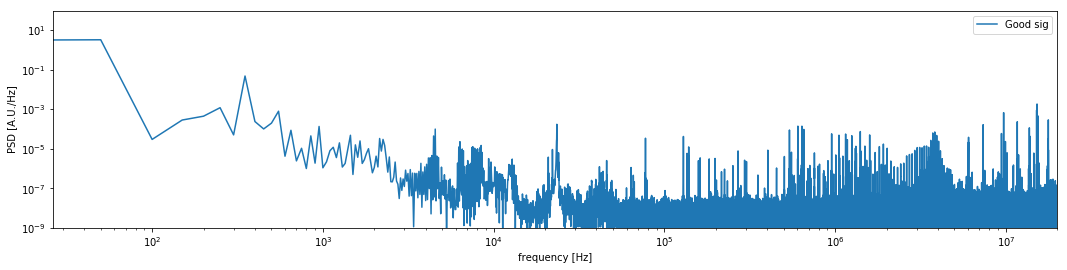

In [9]:
def plot_ps(sig, f_sampling, label='sig', style='loglog'):
    f, Pxx_den = signal.periodogram(sig, f_sampling)
    print(f'{max(f)}, {min(f)}, {max(Pxx_den)}, {min(Pxx_den)}')
    if style == 'semilogy':
        plt.semilogy(f, Pxx_den, label=label)
    else:
        plt.loglog(f, Pxx_den, label=label)
    plt.ylim([1e-9, 1e2])
    plt.xlim([0, 20000000.0])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [A.U./Hz]')
    
plt.rcParams["figure.figsize"] = [18,4] 
plot_ps(sig, f_sampling, 'Good sig')
plt.legend(loc='best')
plt.show()

20000000.0, 0.0, 3.7021496295928955, 3.7955353422708525e-33


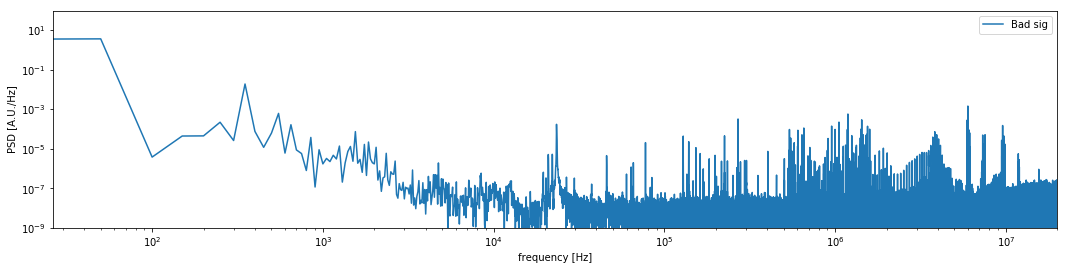

In [10]:
plot_ps(sig_error, f_sampling, 'Bad sig')
plt.legend(loc='best')
plt.show()

In [11]:
def plot_ps_diff(sig, Pxx_den, f_sampling, label='sig', style='loglog'):
    plt.loglog(sig, Pxx_den, label=label)
    plt.ylim([1e-9, 1e-2])
    plt.xlim([0, 20000000.0])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [A.U./Hz]')

In [12]:
f_g, Pxx_den_g = signal.periodogram(sig, f_sampling)
f_b, Pxx_den_b = signal.periodogram(sig_error, f_sampling)

In [13]:
g=f_g*Pxx_den_g
b=f_b*Pxx_den_b


In [14]:
diff=g-b
P_diff = diff/f_g

/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


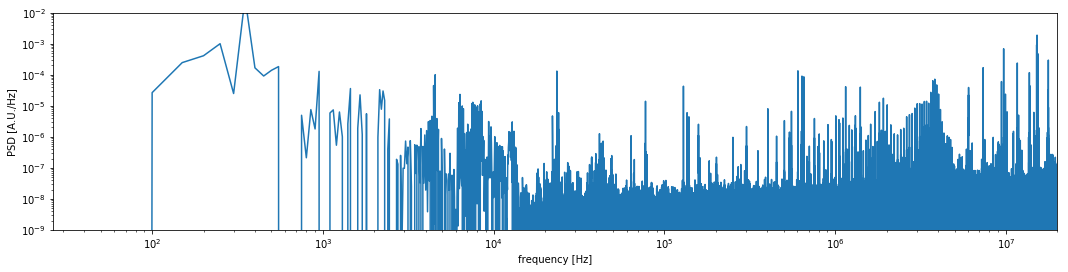

In [15]:
plot_ps_diff(f_g, P_diff, f_sampling, 'Difference')

In [127]:
def bandpassfilter(spec, sample_freq, lowcut, highcut):
    # a digital bandpass filter with a infinite roll off. 
    # Note that we will keep the frequency point right at low cut-off and high cut-off frequencies. 
    #print(f'sample_freq: {sample_freq}')
    spec1 = spec.copy()
    spec1[np.abs(sample_freq) < lowcut] = 0
    spec1[np.abs(sample_freq) > highcut] = 0
    filtered_sig = fftpack.ifft(spec1)
    return filtered_sig

/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


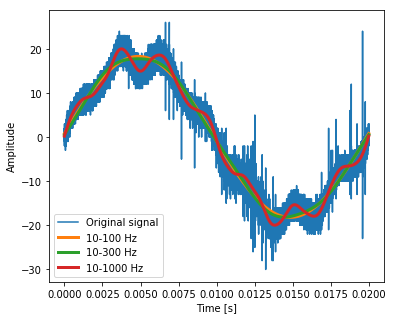

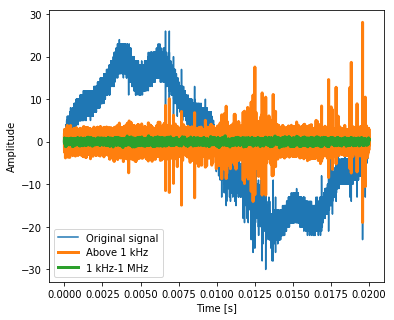

In [17]:
# Digital filtering
# peak_freq should be 50 Hz. 
# We demonstrated differnt low-pass filtered signals. You can see 10-1000 Hz can capture a lot of low frequency features. 
lowcut, highcut = 10, 100
filtered_sig0 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 10, 300
filtered_sig1 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 10, 1000
filtered_sig2 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig0, linewidth=3, label='10-100 Hz')
plt.plot(time_vec, filtered_sig1, linewidth=3, label='10-300 Hz')
plt.plot(time_vec, filtered_sig2, linewidth=3, label='10-1000 Hz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 1000, 1e6
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 1000, 40e6
filtered_sig4 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig4, linewidth=3, label='Above 1 kHz')
plt.plot(time_vec, filtered_sig3, linewidth=3, label='1 kHz-1 MHz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')


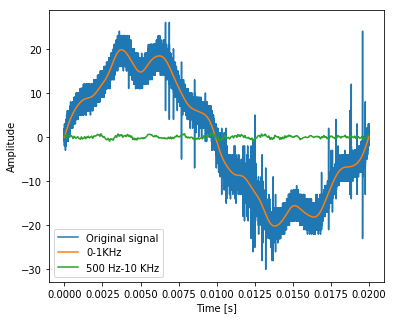

In [18]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 0, 1000
filtered_sig1 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 500, 1e4
filtered_sig2 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 1000, 1e6
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 1000, 40e6
filtered_sig4 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig1, label='0-1KHz')
plt.plot(time_vec, filtered_sig2, label='500 Hz-10 KHz')
#plt.plot(time_vec, filtered_sig4, linewidth=3, label='1 KHz-40 MHz')
#plt.plot(time_vec, filtered_sig3, linewidth=3, label='1 kHz-1 MHz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

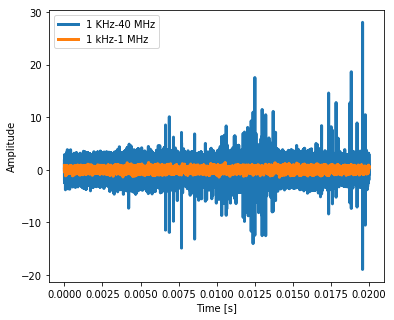

In [ ]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 1000, 1e6
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 1000, 40e6
filtered_sig4 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.figure(figsize=(6, 5))
#plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig4, linewidth=3, label='1 KHz-40 MHz')
plt.plot(time_vec, filtered_sig3, linewidth=3, label='1 kHz-1 MHz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

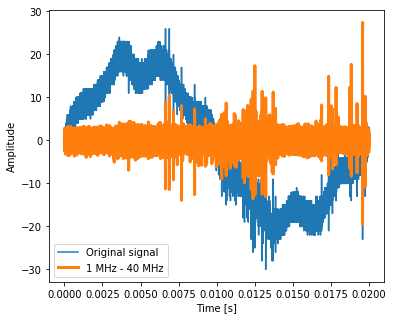

In [ ]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 1e6, 40e6
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 1000, 40e6
filtered_sig4 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
#plt.plot(time_vec, filtered_sig4, linewidth=3, label='1 KHz-40 MHz')
plt.plot(time_vec, filtered_sig3, linewidth=3, label='1 MHz - 40 MHz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

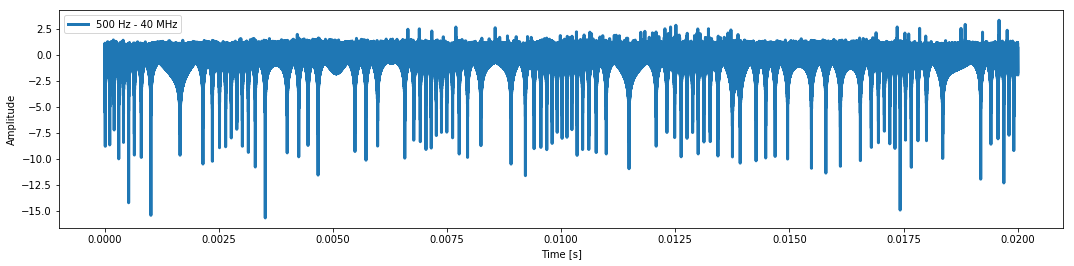

In [ ]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 500, 40e6
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
nlog_3 = np.log(filtered_sig3)
plt.figure(figsize=(18,4))
plt.plot(time_vec, nlog_3, linewidth=3, label='500 Hz - 40 MHz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

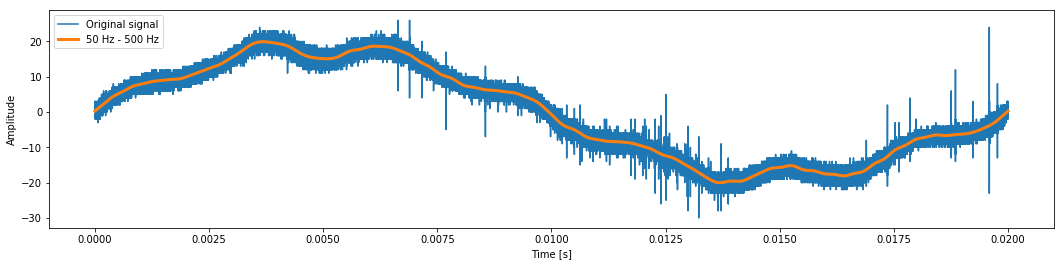

In [ ]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 40, 2500
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.figure(figsize=(18,4))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig3, linewidth=3, label='50 Hz - 500 Hz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

In [ ]:
hf_sig = sig-filtered_sig3

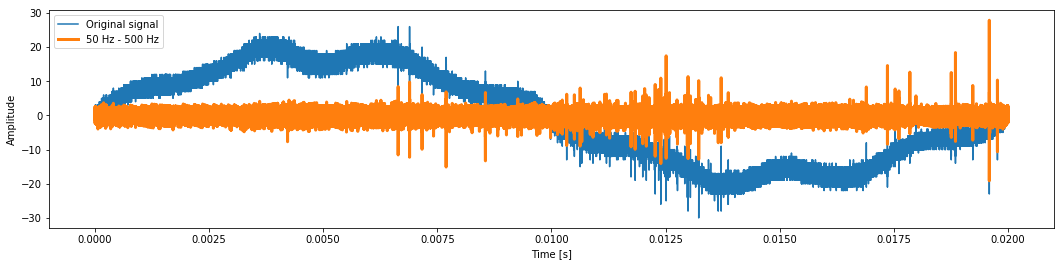

In [ ]:

plt.figure(figsize=(18,4))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, hf_sig, linewidth=3, label='50 Hz - 500 Hz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

In [130]:
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

In [ ]:
sample_freq[:10]

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.])

In [ ]:
sig.size

800000

### Frequency domain

In [18]:
train_set=xs
meta_train=train_meta

In [19]:
#FFT to filter out HF components and get main signal profile
def low_pass(s, threshold=1e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [35]:
###Filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [52]:
def phase_indices(three_phase_sig):
    phase1 = 3*three_phase_sig
    phase2 = 3*three_phase_sig + 1
    phase3 = 3*three_phase_sig + 2
    print(phase1,phase2,phase3)
    return phase1,phase2,phase3

#### good 3 phase signals

In [155]:
def print_targets(id_meas):
    targets=train_meta.loc[train_meta['id_measurement']==id_meas]
    print(targets.head())

In [156]:
good_idm=train_good_id_measurement[5]
print_targets(good_idm)

    signal_id  id_measurement  phase  target
18         18               6      0       0
19         19               6      1       0
20         20               6      2       0


In [157]:
#2904 three_phase_sigs  

three_phase_sig = good_idm
p1,p2,p3 = phase_indices(three_phase_sig)

18 19 20


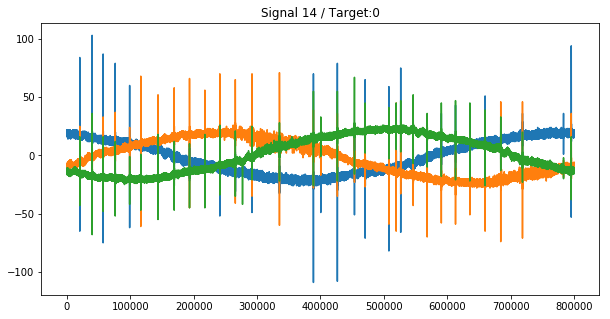

In [158]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(train_set.iloc[:,p1])
plt.plot(train_set.iloc[:,p2])
plt.plot(train_set.iloc[:,p3])

In [159]:
lf_signal_1 = low_pass(train_set.iloc[:,p1])
lf_signal_2 = low_pass(train_set.iloc[:,p2])
lf_signal_3 = low_pass(train_set.iloc[:,p3])

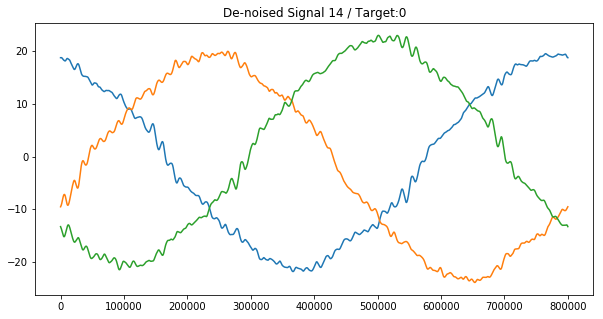

In [160]:
plt.figure(figsize=(10,5))
plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)

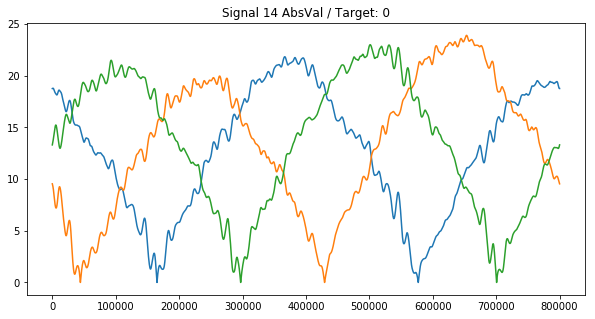

In [161]:
plt.figure(figsize=(10,5))
plt.title('Signal %d AbsVal / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(np.abs(lf_signal_1))
plt.plot(np.abs(lf_signal_2))
plt.plot(np.abs(lf_signal_3))

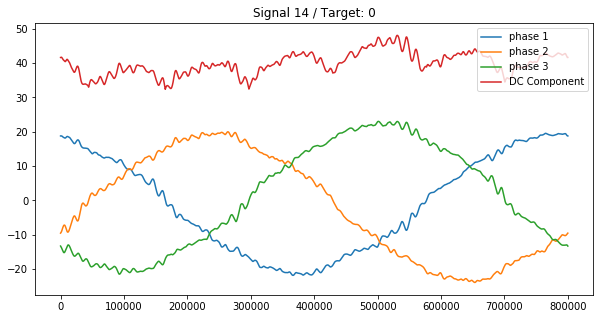

In [162]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)
plt.plot((np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)))
plt.legend(['phase 1','phase 2','phase 3','DC Component'],loc=1)

In [163]:
hf_signal_1 = high_pass(train_set.iloc[:,p1])
hf_signal_2 = high_pass(train_set.iloc[:,p2])
hf_signal_3 = high_pass(train_set.iloc[:,p3])

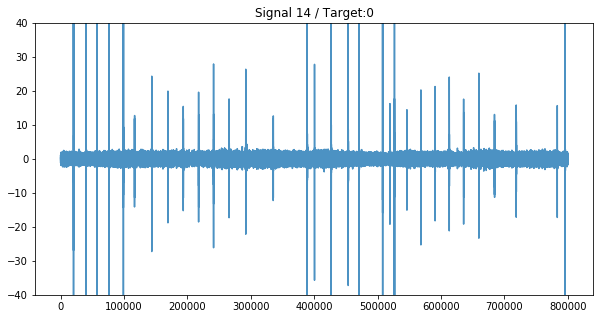

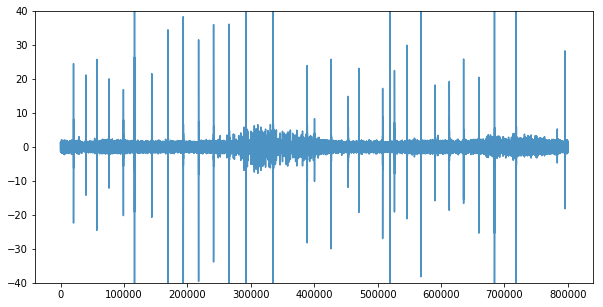

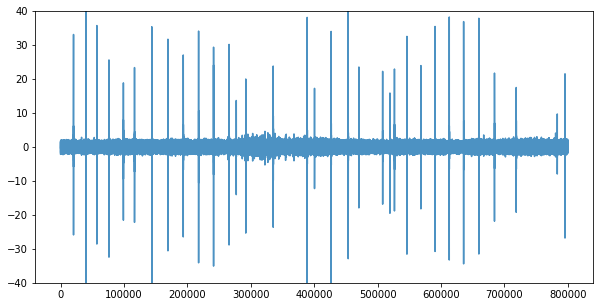

In [164]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(hf_signal_1, alpha=0.8)
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(hf_signal_2, alpha=0.8)
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(hf_signal_3, alpha=0.8)
plt.ylim(-40,40)
plt.show()

In [165]:
diff_1_2=hf_signal_1-hf_signal_2
diff_2_3=hf_signal_2-hf_signal_3
diff_1_3=hf_signal_1-hf_signal_3

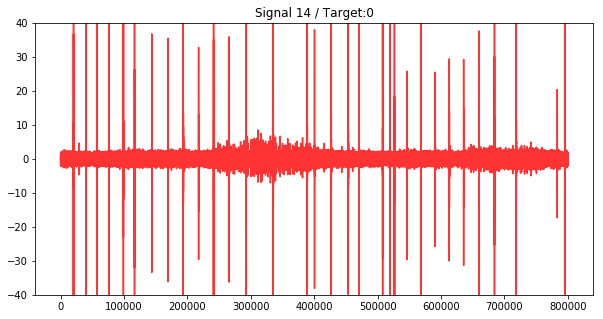

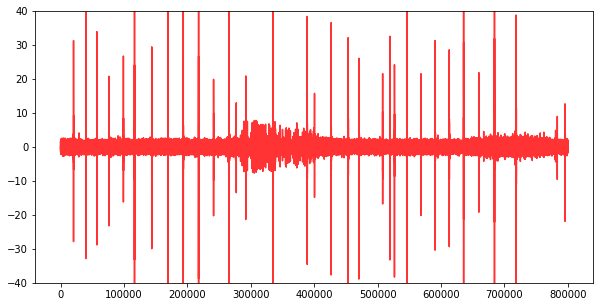

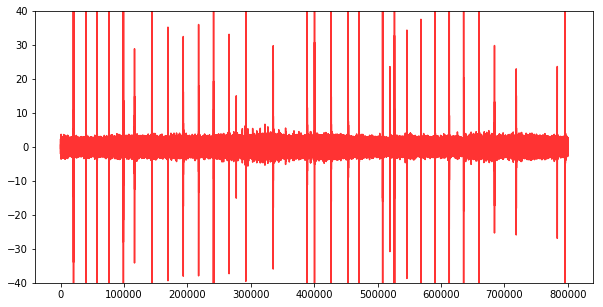

In [166]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(diff_1_2, alpha=0.8, color='r')
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(diff_2_3, alpha=0.8, color='r')
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(diff_1_3, alpha=0.8, color='r')
plt.ylim(-40,40)
plt.show()

In [209]:
def plot_n_goods(start=0, n=10):
    for i in range(n):
        id_m=train_good_id_measurement[start+i]
        targets=list(train_meta.loc[train_meta['id_measurement']==id_m]['target'])
        assert 1 not in targets
        p1,p2,p3 = phase_indices(id_m)
        hf_signal_1 = high_pass(train_set.iloc[:,p1])
        hf_signal_2 = high_pass(train_set.iloc[:,p2])
        hf_signal_3 = high_pass(train_set.iloc[:,p3])
        
        lf_signal_1 = low_pass(train_set.iloc[:,p1], threshold=100)
        lf_signal_2 = low_pass(train_set.iloc[:,p2], threshold=100)
        lf_signal_3 = low_pass(train_set.iloc[:,p3], threshold=100)
        
        plt.subplot(311)
        plt.plot(hf_signal_1)
        plt.plot(lf_signal_1)
        plt.ylim(-40,40)
        plt.subplot(312)
        plt.plot(hf_signal_2)
        plt.plot(lf_signal_2)
        plt.ylim(-40,40)
        plt.subplot(313)
        plt.plot(hf_signal_3)
        plt.plot(lf_signal_3)
        plt.ylim(-40,40)
        plt.show()

In [ ]:
plot_n_goods(start=0, n=100)

In [ ]:
plot_n_goods(start=100, n=100)

### bad 3 phase plots

In [78]:
#good ids:
#train_good_idms
#bad ids
#train_meta_error_3_phase_sig_ids
len(train_good_idms), len(train_meta_error_3_phase_sig_ids)

(2710, 194)

In [81]:
train_meta_error_3_phase_sig_ids[:10]

3        3
201    201
228    228
270    270
279    279
285    285
288    288
294    294
378    378
408    408
Name: signal_id, dtype: int64

In [204]:
bad_id_m=train_meta_error_id_measurement[3]
print_targets(bad_id_m)

     signal_id  id_measurement  phase  target
270        270              90      0       1
271        271              90      1       1
272        272              90      2       1


In [205]:
#get a new phase set
bthree_phase_sig = train_meta_error_id_measurement[3]
bp1,bp2,bp3 = phase_indices(bthree_phase_sig)

270 271 272


In [206]:
bhf_signal_1 = high_pass(train_set.iloc[:,bp1])
bhf_signal_2 = high_pass(train_set.iloc[:,bp2])
bhf_signal_3 = high_pass(train_set.iloc[:,bp3])

In [207]:
blf_signal_1 = low_pass(train_set.iloc[:,bp1], threshold=100)
blf_signal_2 = low_pass(train_set.iloc[:,bp2], threshold=100)
blf_signal_3 = low_pass(train_set.iloc[:,bp3], threshold=100)

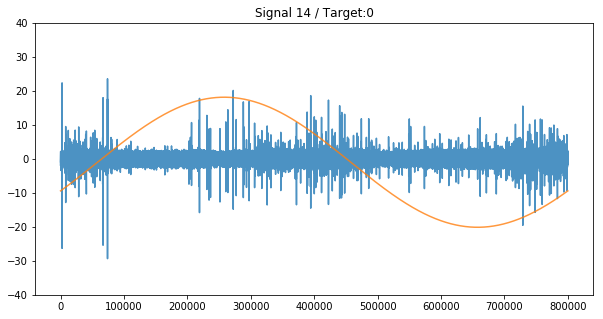

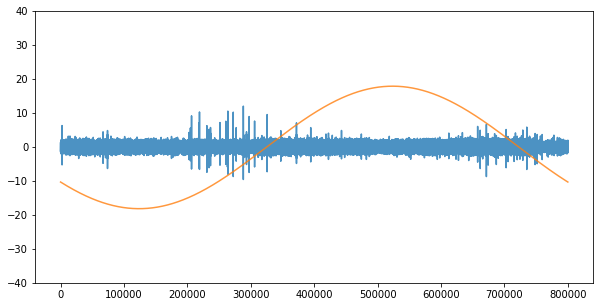

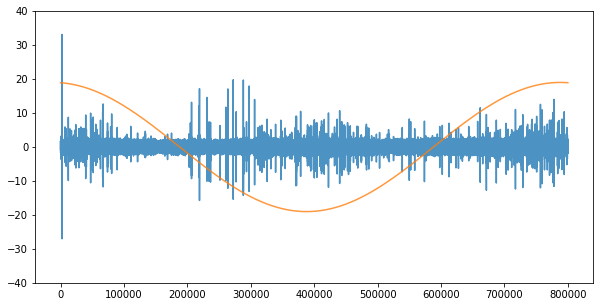

In [208]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(bhf_signal_1, alpha=0.8)
plt.plot(blf_signal_1, alpha=0.8)
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bhf_signal_2, alpha=0.8)
plt.plot(blf_signal_2, alpha=0.8)
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bhf_signal_3, alpha=0.8)
plt.plot(blf_signal_3, alpha=0.8)
plt.ylim(-40,40)
plt.show()

Interesting that the HF component of all 3 phases is pretty similar

In [180]:
bdiff_1_2=bhf_signal_1-bhf_signal_2
bdiff_2_3=bhf_signal_2-bhf_signal_3
bdiff_1_3=bhf_signal_1-bhf_signal_3

In [181]:
btotal_diff = abs(bdiff_1_2)+abs(bdiff_2_3)+abs(bdiff_1_3)

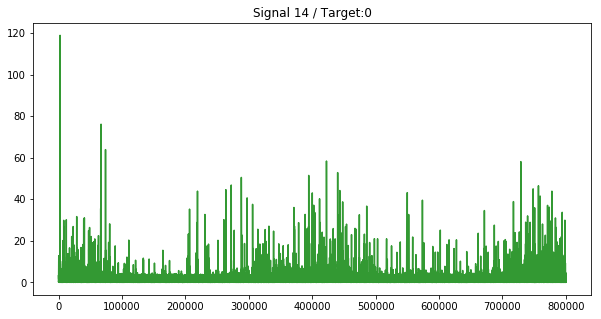

In [182]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(btotal_diff, alpha=0.8, color='g')
plt.show()

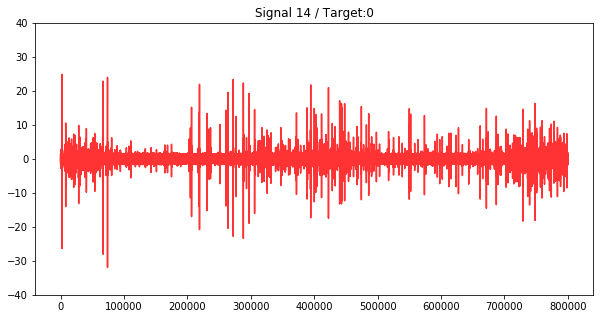

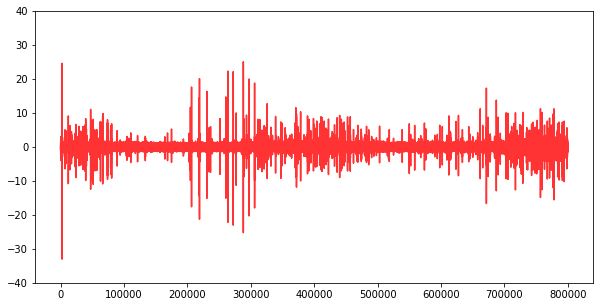

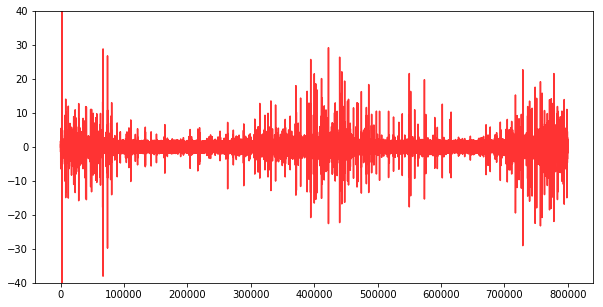

In [183]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(bdiff_1_2, alpha=0.8, color='r')
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bdiff_2_3, alpha=0.8, color='r')
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bdiff_1_3, alpha=0.8, color='r')
plt.ylim(-40,40)
plt.show()

### plot lots of bads

In [212]:
def plot_n_bads(start=0, n=10):
    for i in range(n):
        bad_id_m=train_meta_error_id_measurement[start+i]
        targets=list(train_meta.loc[train_meta['id_measurement']==bad_id_m]['target'])
        assert 1 in targets
        bp1,bp2,bp3 = phase_indices(bad_id_m)
        bhf_signal_1 = high_pass(train_set.iloc[:,bp1])
        bhf_signal_2 = high_pass(train_set.iloc[:,bp2])
        bhf_signal_3 = high_pass(train_set.iloc[:,bp3])
        
        lf_signal_1 = low_pass(train_set.iloc[:,bp1], threshold=100)
        lf_signal_2 = low_pass(train_set.iloc[:,bp2], threshold=100)
        lf_signal_3 = low_pass(train_set.iloc[:,bp3], threshold=100)
        
        plt.subplot(311)
        plt.plot(bhf_signal_1)
        plt.plot(lf_signal_1)
        plt.ylim(-40,40)
        plt.subplot(312)
        plt.plot(bhf_signal_2)
        plt.plot(lf_signal_2)
        plt.ylim(-40,40)
        plt.subplot(313)
        plt.plot(bhf_signal_3)
        plt.plot(lf_signal_3)
        plt.ylim(-40,40)
        plt.show()
        

3 4 5


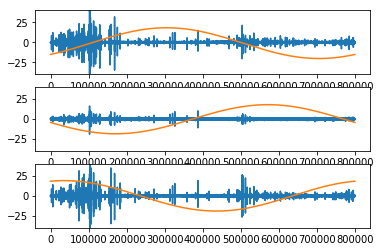

201 202 203


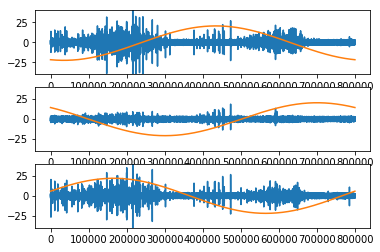

228 229 230


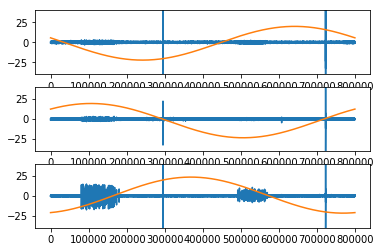

270 271 272


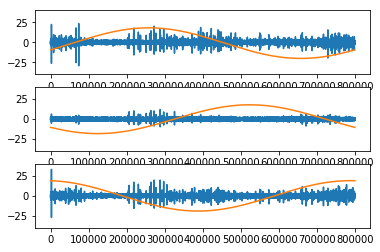

279 280 281


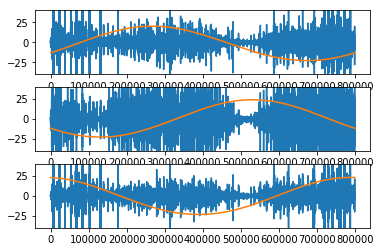

285 286 287


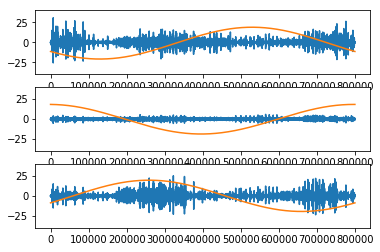

288 289 290


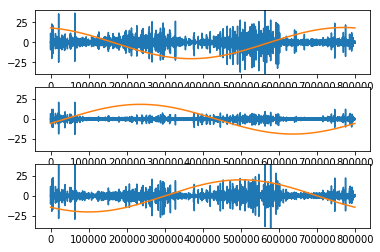

294 295 296


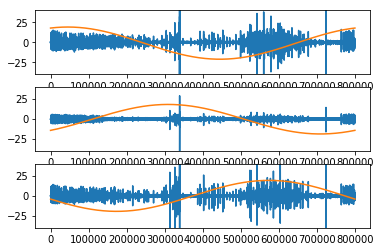

378 379 380


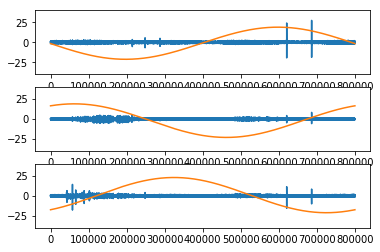

408 409 410


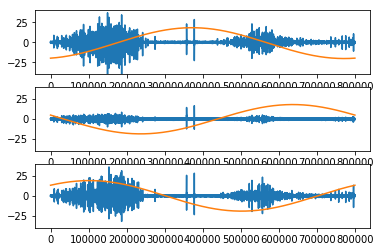

432 433 434


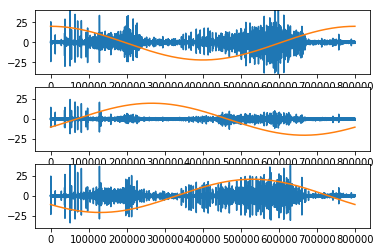

435 436 437


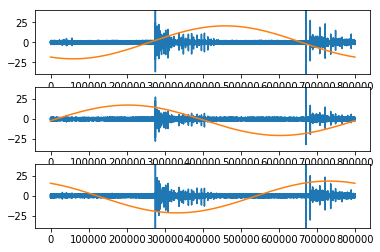

456 457 458


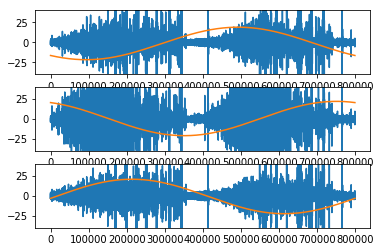

477 478 479


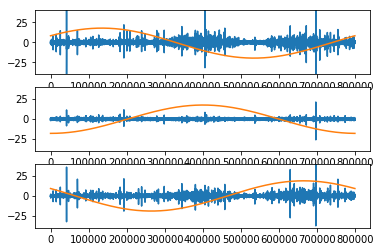

516 517 518


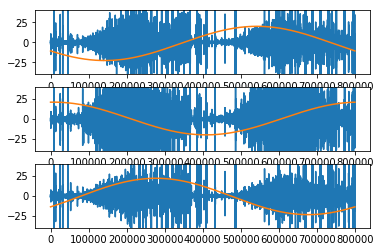

570 571 572


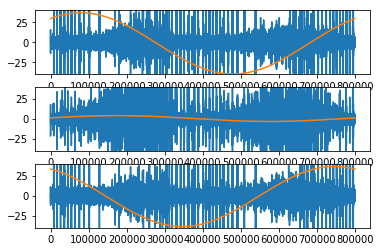

678 679 680


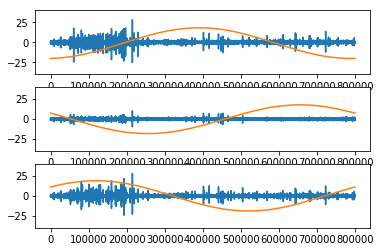

699 700 701


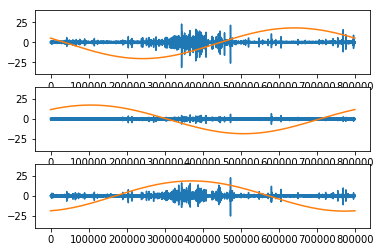

705 706 707


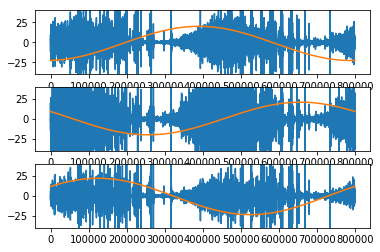

708 709 710


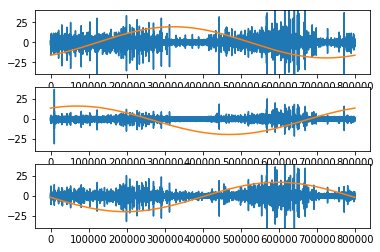

813 814 815


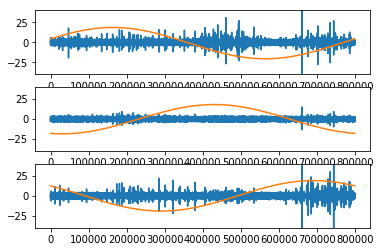

876 877 878


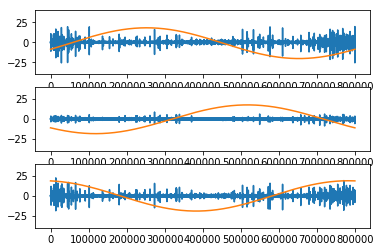

903 904 905


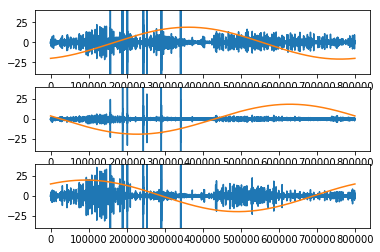

912 913 914


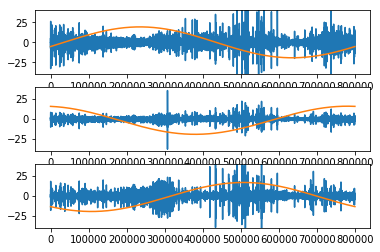

939 940 941


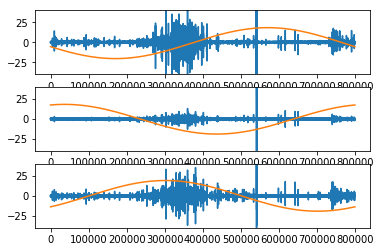

1002 1003 1004


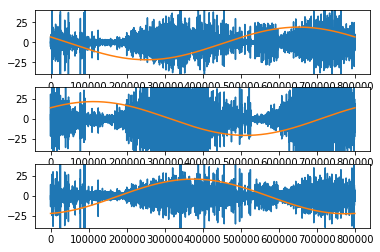

1017 1018 1019


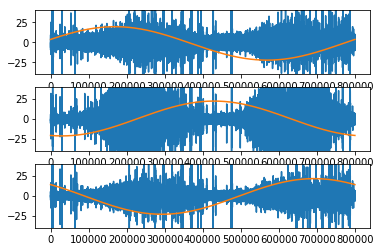

1026 1027 1028


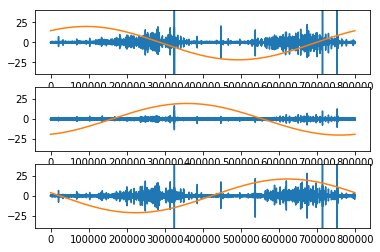

1032 1033 1034


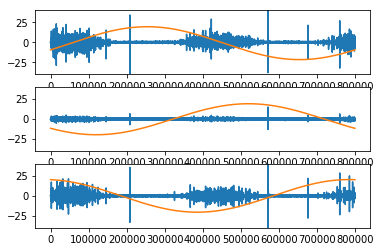

1050 1051 1052


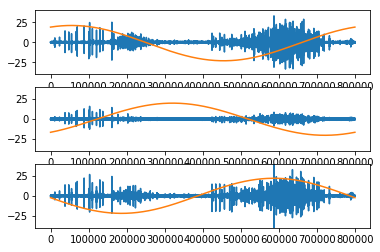

1074 1075 1076


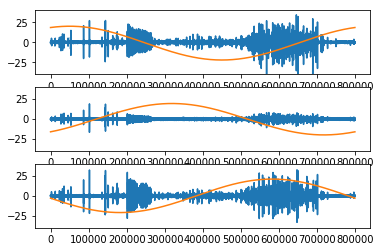

1083 1084 1085


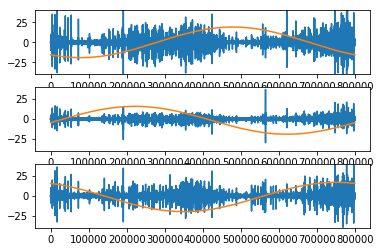

1134 1135 1136


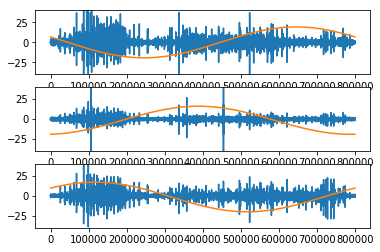

1263 1264 1265


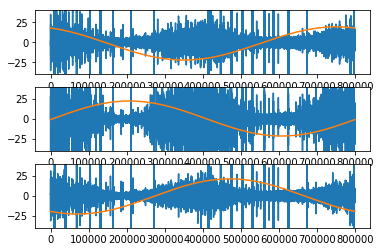

1329 1330 1331


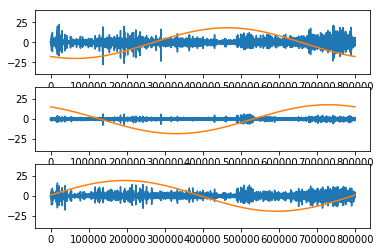

1335 1336 1337


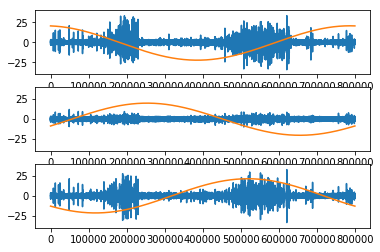

1434 1435 1436


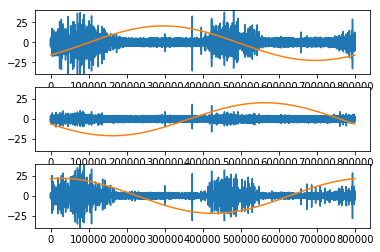

1449 1450 1451


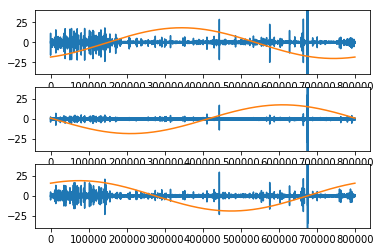

1455 1456 1457


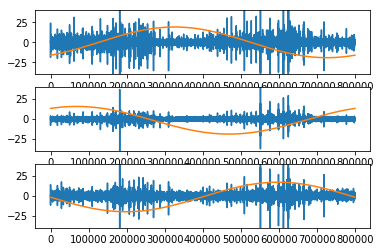

1554 1555 1556


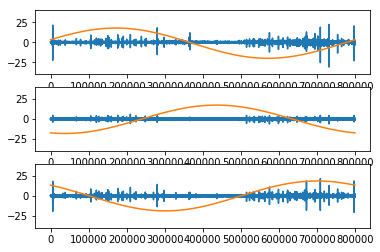

1575 1576 1577


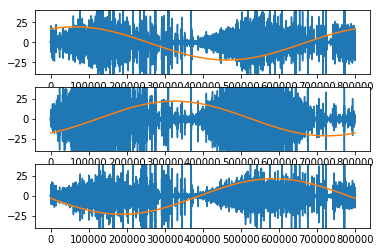

1737 1738 1739


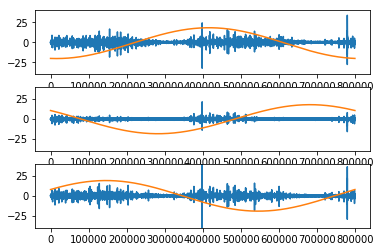

1803 1804 1805


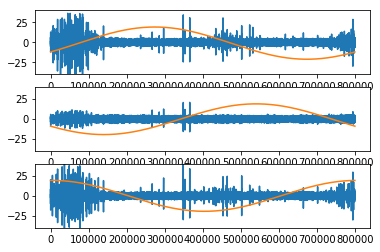

1824 1825 1826


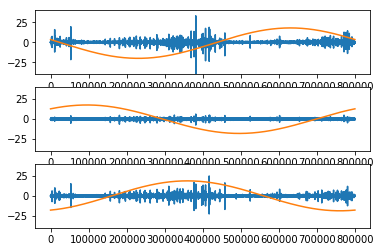

1860 1861 1862


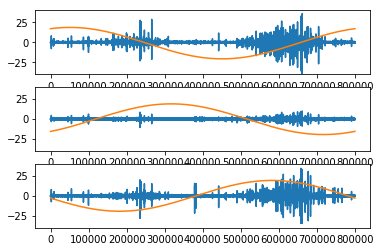

1884 1885 1886


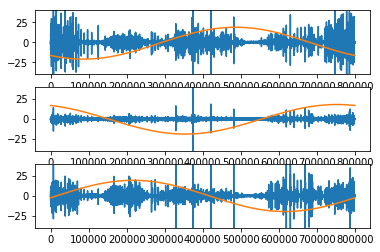

1899 1900 1901


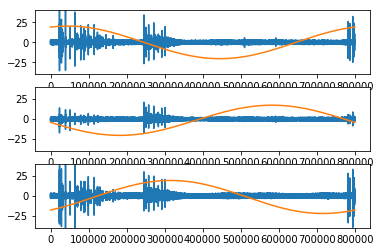

1992 1993 1994


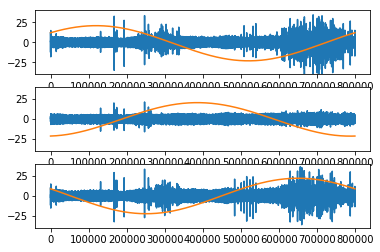

2085 2086 2087


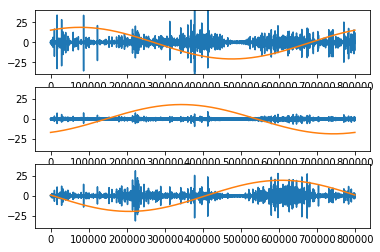

2097 2098 2099


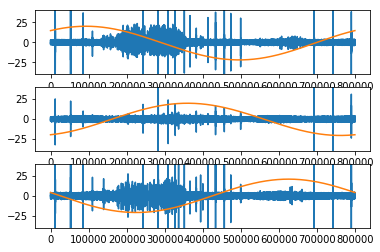

2115 2116 2117


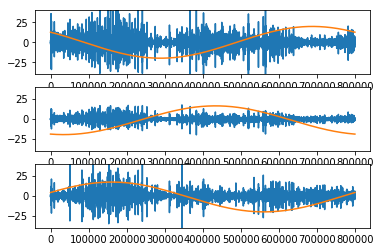

2118 2119 2120


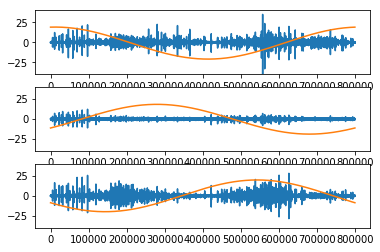

2139 2140 2141


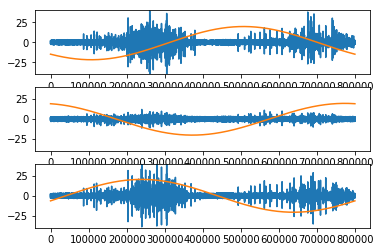

2160 2161 2162


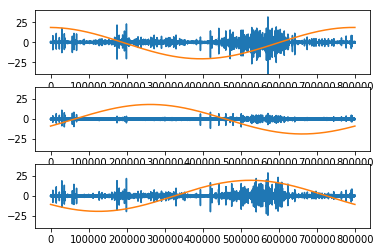

2169 2170 2171


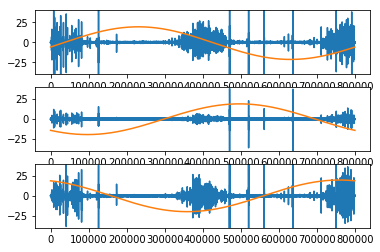

2193 2194 2195


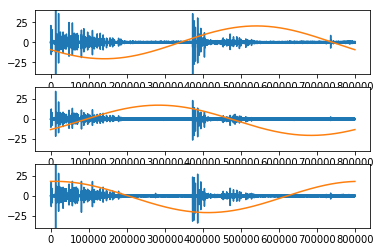

2277 2278 2279


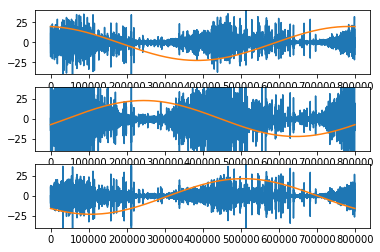

2307 2308 2309


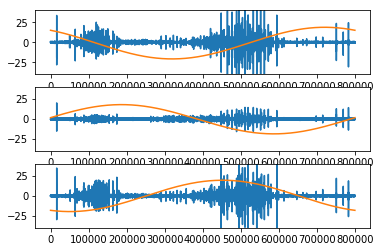

2322 2323 2324


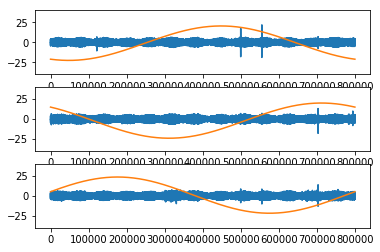

2343 2344 2345


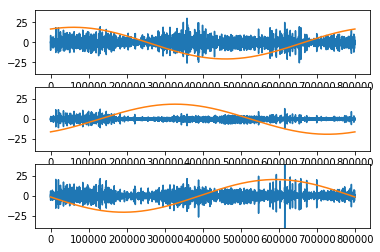

2352 2353 2354


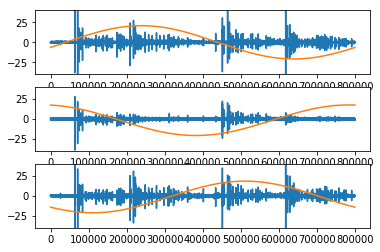

2418 2419 2420


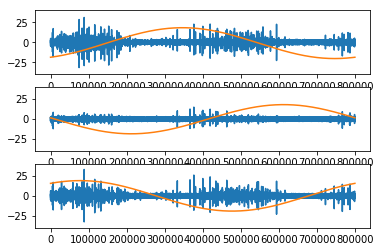

2514 2515 2516


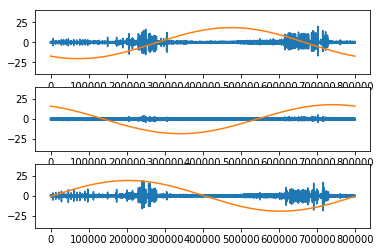

2628 2629 2630


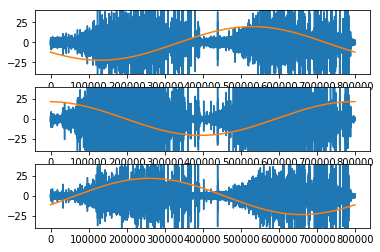

2640 2641 2642


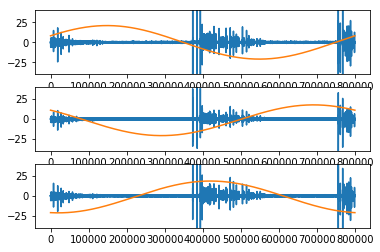

2682 2683 2684


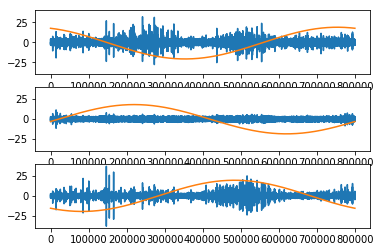

2832 2833 2834


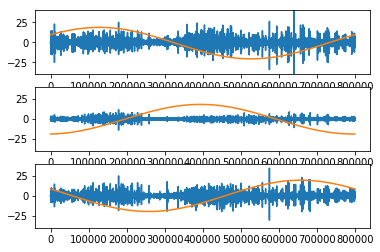

2904 2905 2906


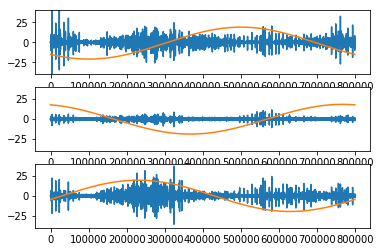

2952 2953 2954


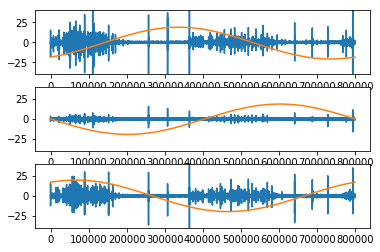

2964 2965 2966


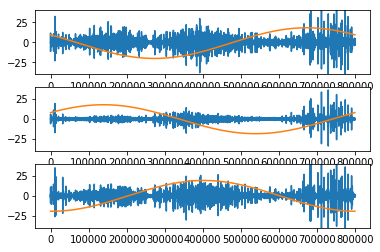

2985 2986 2987


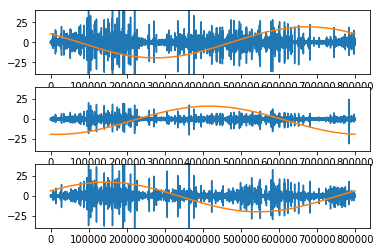

3030 3031 3032


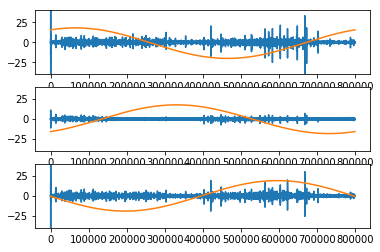

3204 3205 3206


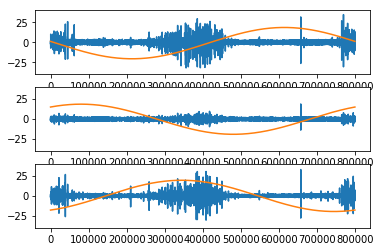

3228 3229 3230


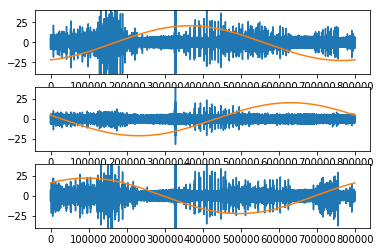

3237 3238 3239


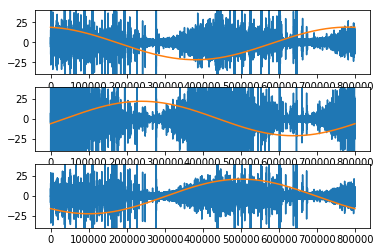

3243 3244 3245


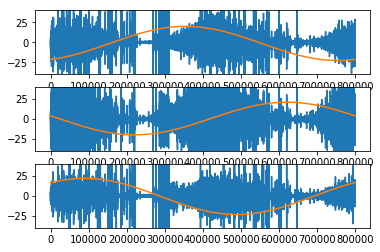

3273 3274 3275


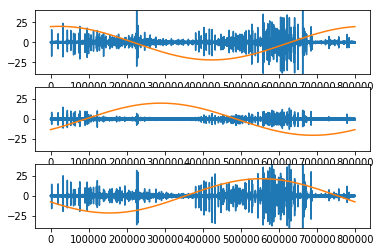

3309 3310 3311


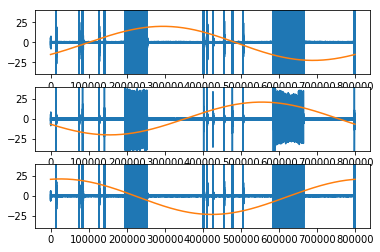

3345 3346 3347


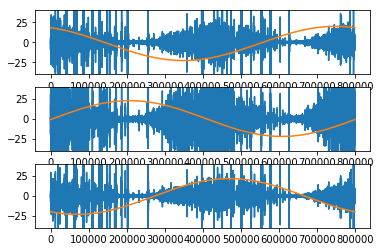

3372 3373 3374


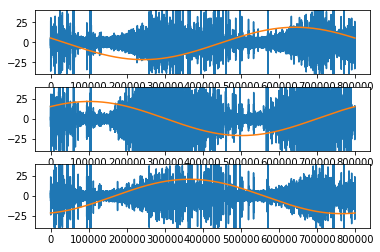

3396 3397 3398


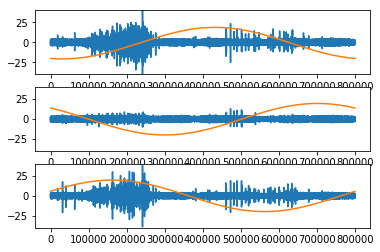

3519 3520 3521


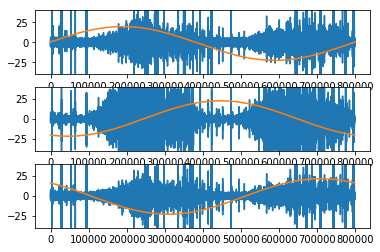

3534 3535 3536


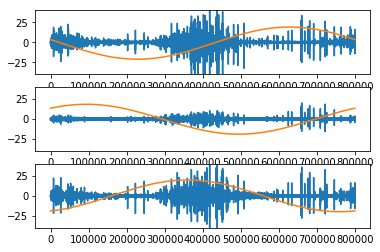

3570 3571 3572


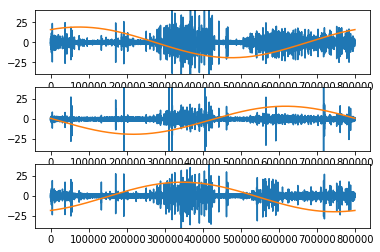

3612 3613 3614


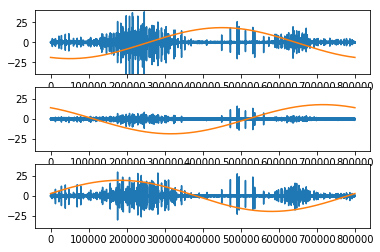

3768 3769 3770


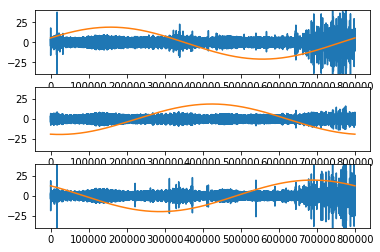

3804 3805 3806


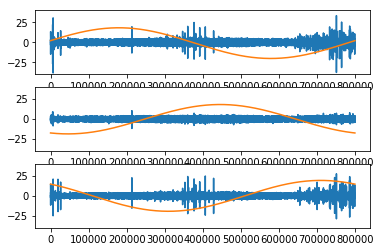

3831 3832 3833


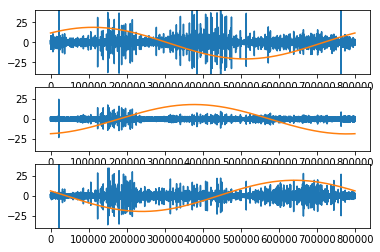

3912 3913 3914


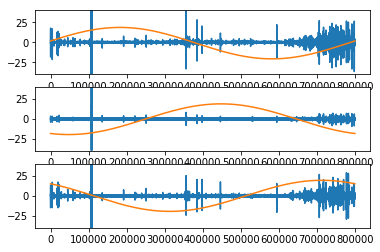

3978 3979 3980


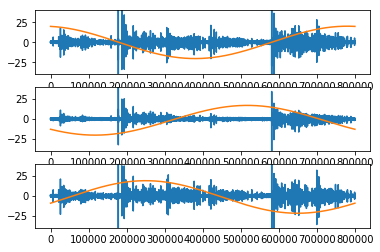

4035 4036 4037


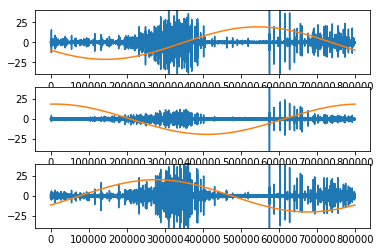

4053 4054 4055


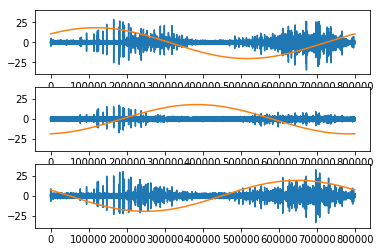

4068 4069 4070


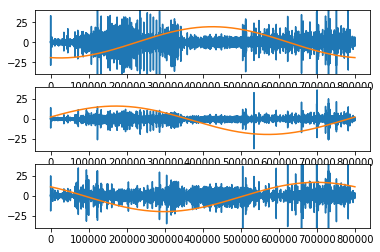

4086 4087 4088


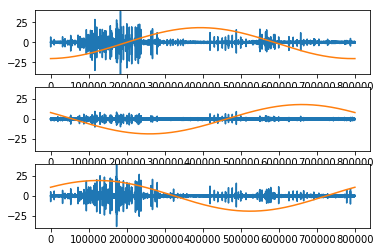

4125 4126 4127


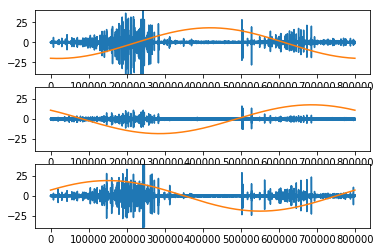

4143 4144 4145


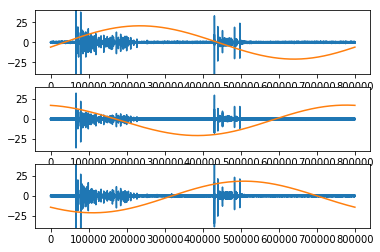

4158 4159 4160


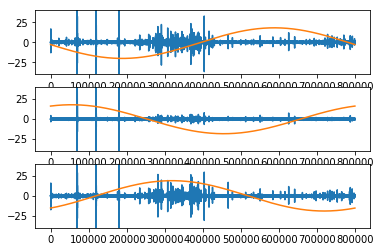

4164 4165 4166


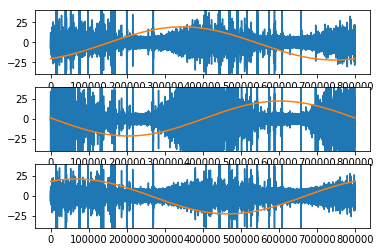

4212 4213 4214


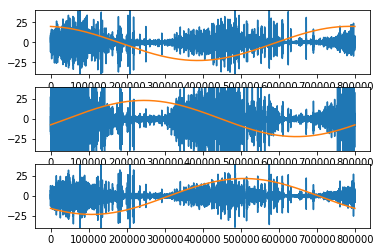

4221 4222 4223


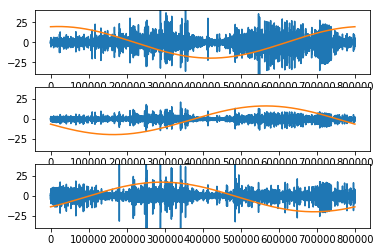

In [218]:
plot_n_bads(start=0, n=100)

In [214]:
#378 379 380 do not look bad (these are idm 126)
list(train_meta.loc[train_meta['id_measurement']==126]['target'])

[0, 0, 1]

4224 4225 4226


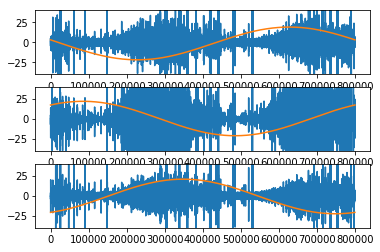

4233 4234 4235


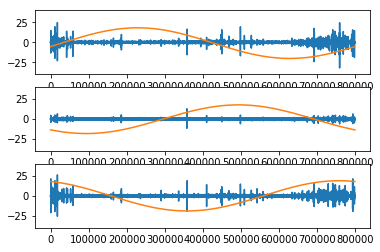

4239 4240 4241


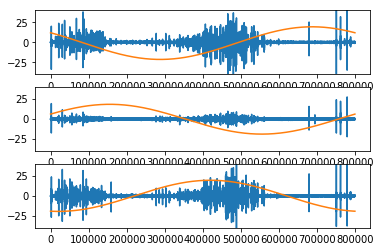

4248 4249 4250


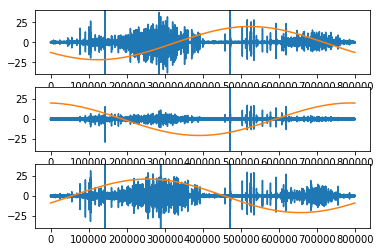

4257 4258 4259


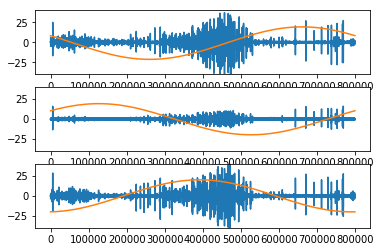

4260 4261 4262


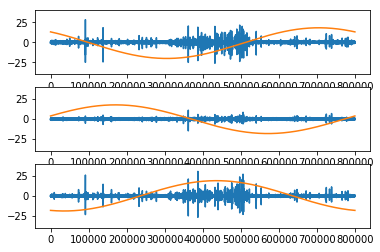

4332 4333 4334


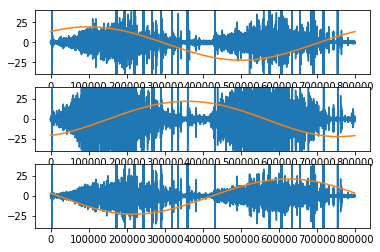

4350 4351 4352


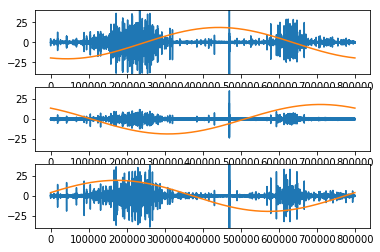

4353 4354 4355


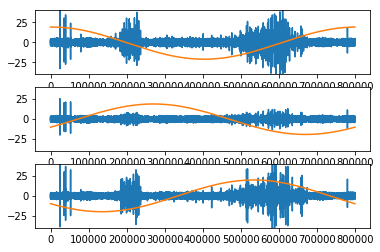

4548 4549 4550


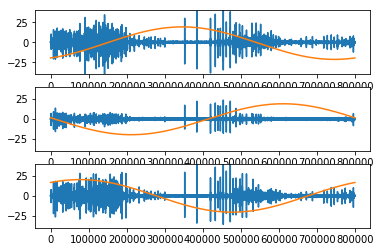

4578 4579 4580


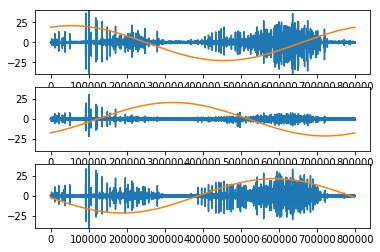

4596 4597 4598


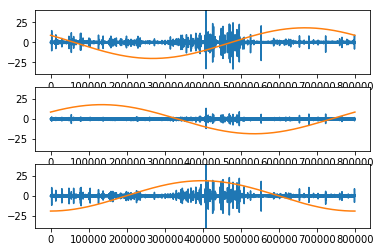

4611 4612 4613


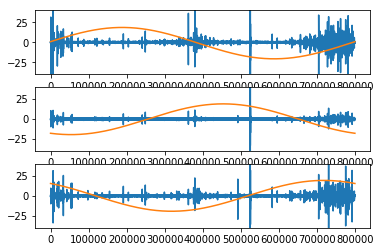

4632 4633 4634


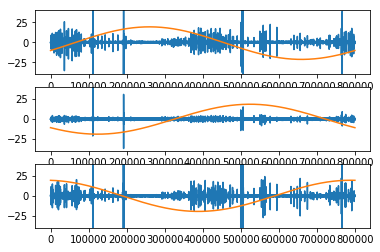

4683 4684 4685


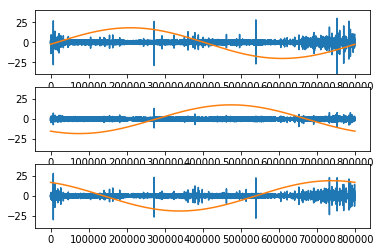

4692 4693 4694


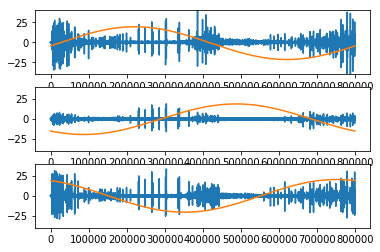

4713 4714 4715


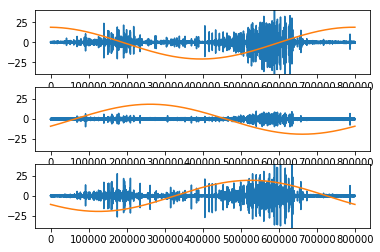

4737 4738 4739


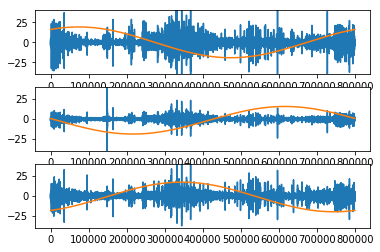

4767 4768 4769


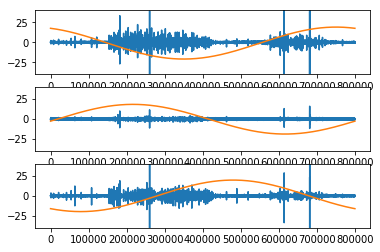

4815 4816 4817


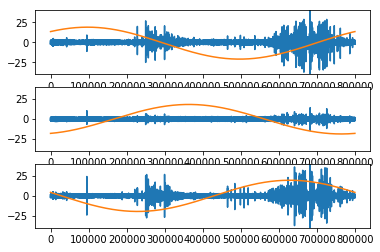

4836 4837 4838


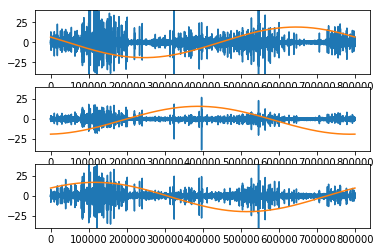

4872 4873 4874


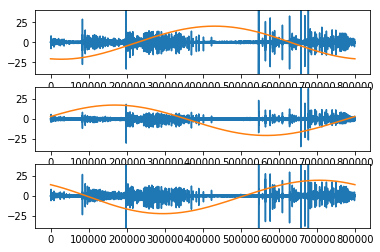

4932 4933 4934


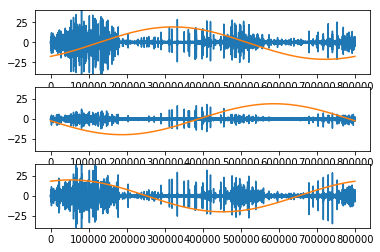

4938 4939 4940


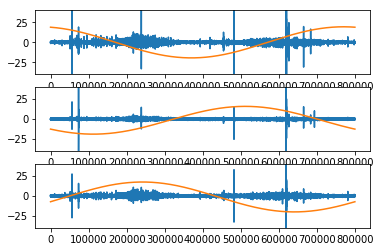

5004 5005 5006


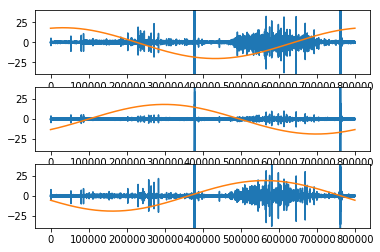

5007 5008 5009


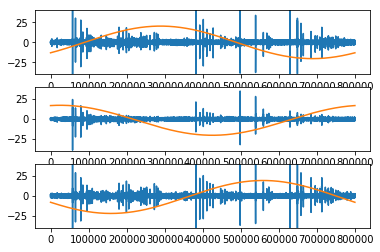

5016 5017 5018


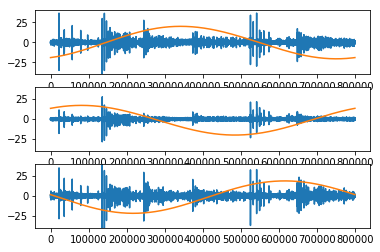

5019 5020 5021


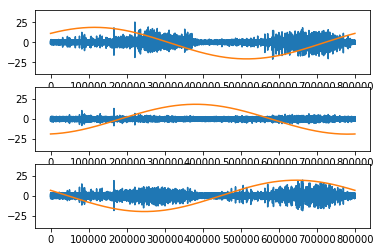

5061 5062 5063


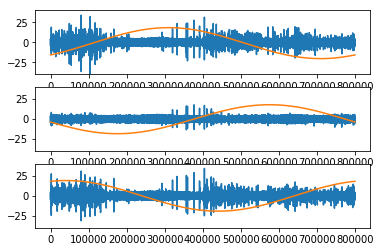

5112 5113 5114


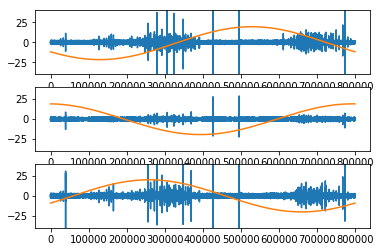

5181 5182 5183


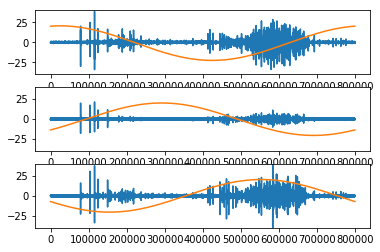

5196 5197 5198


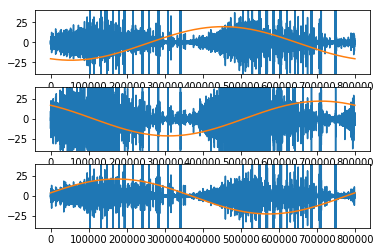

5250 5251 5252


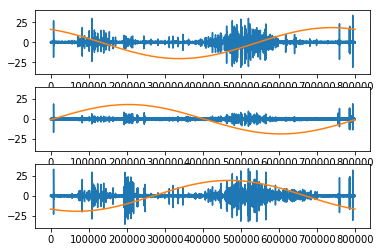

5283 5284 5285


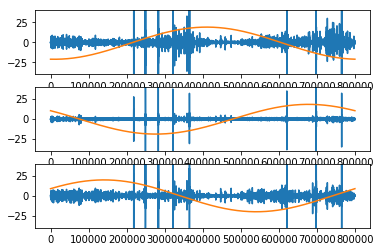

5307 5308 5309


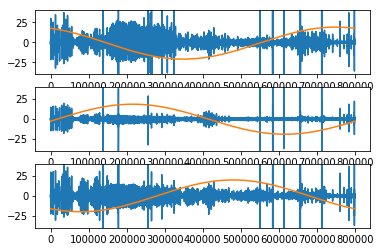

5316 5317 5318


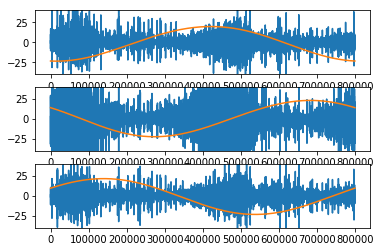

5364 5365 5366


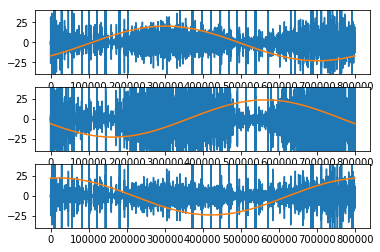

5367 5368 5369


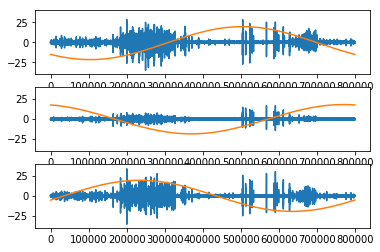

5487 5488 5489


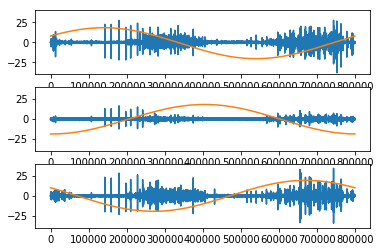

5541 5542 5543


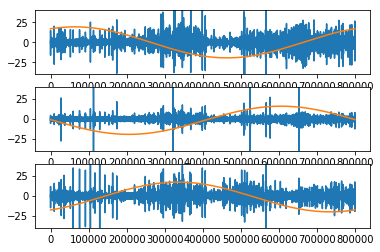

5652 5653 5654


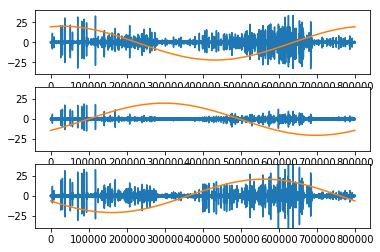

5697 5698 5699


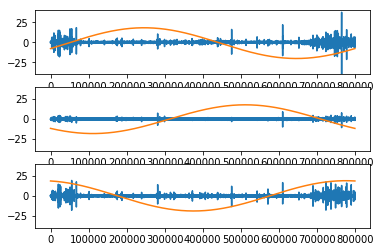

5730 5731 5732


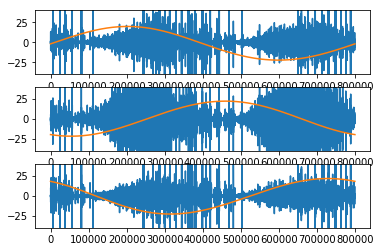

5943 5944 5945


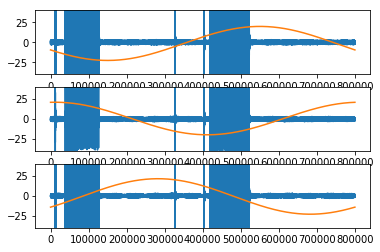

5982 5983 5984


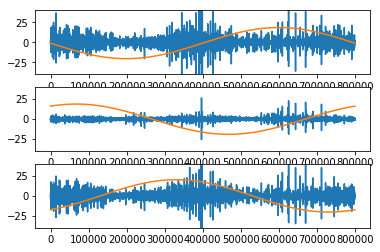

6228 6229 6230


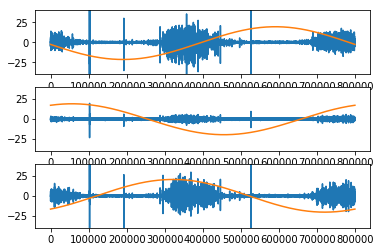

6243 6244 6245


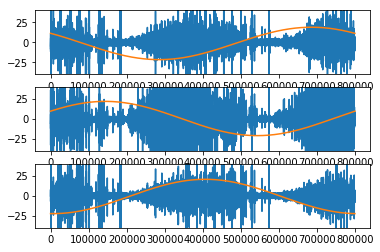

6276 6277 6278


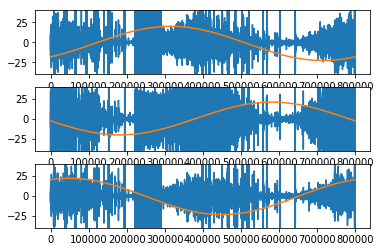

6282 6283 6284


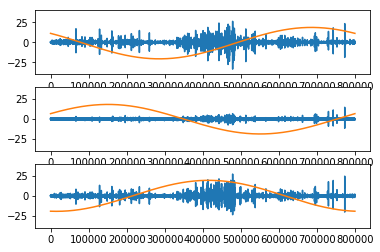

6303 6304 6305


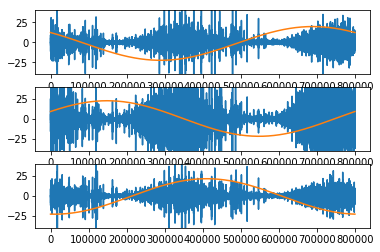

6351 6352 6353


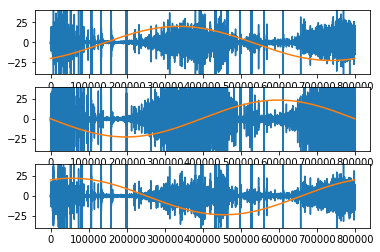

6378 6379 6380


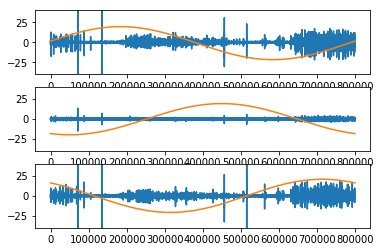

6501 6502 6503


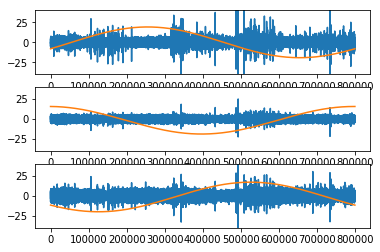

6525 6526 6527


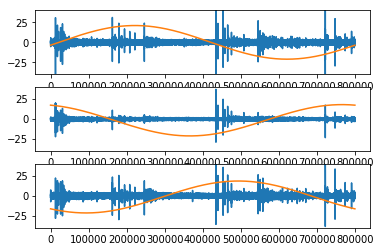

6636 6637 6638


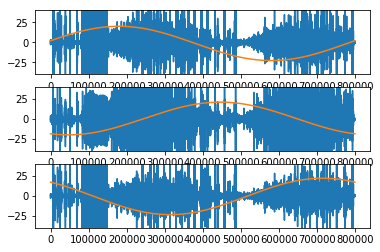

6639 6640 6641


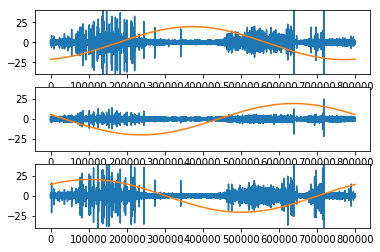

6654 6655 6656


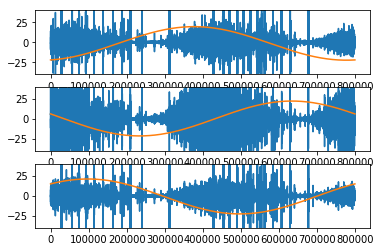

6672 6673 6674


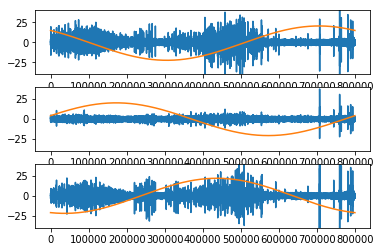

6690 6691 6692


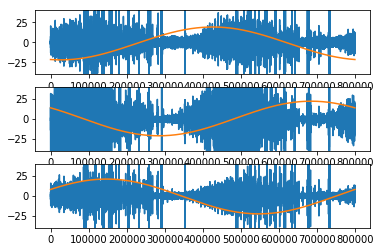

6744 6745 6746


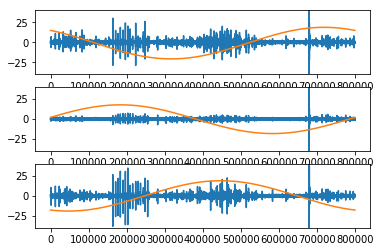

6759 6760 6761


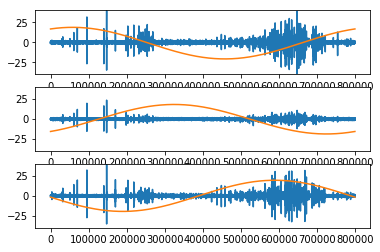

6822 6823 6824


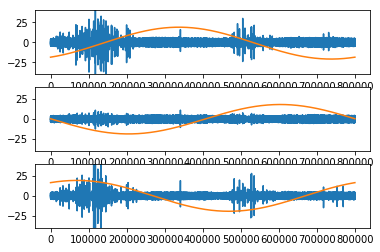

6942 6943 6944


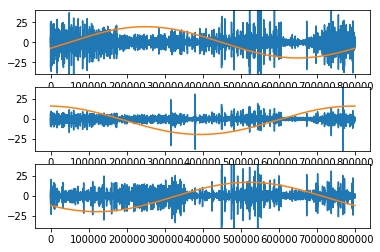

6966 6967 6968


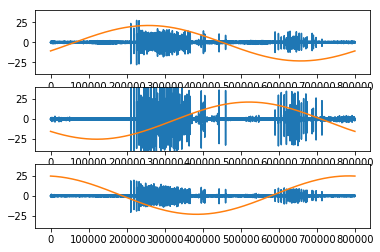

6984 6985 6986


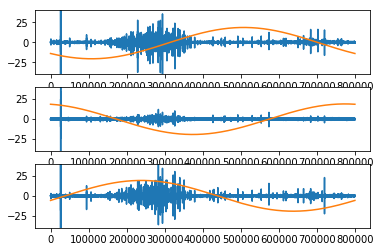

7005 7006 7007


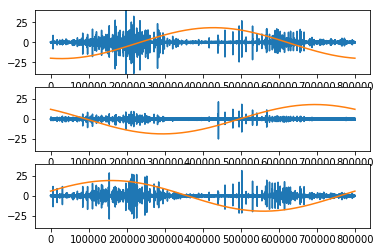

7020 7021 7022


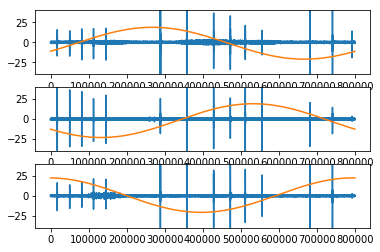

7119 7120 7121


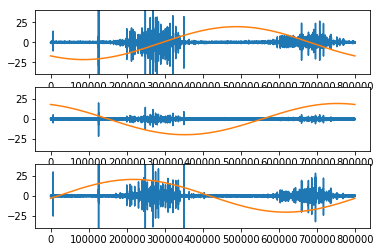

7308 7309 7310


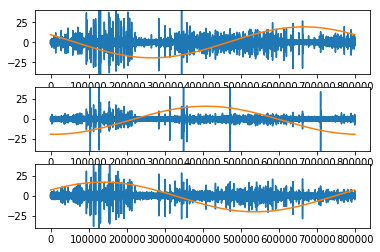

7467 7468 7469


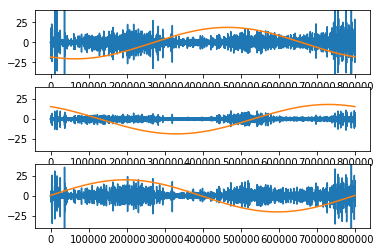

7482 7483 7484


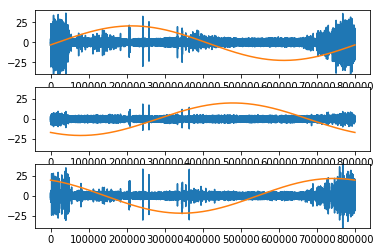

7512 7513 7514


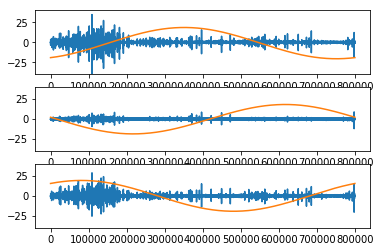

7620 7621 7622


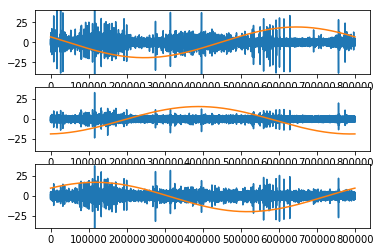

7644 7645 7646


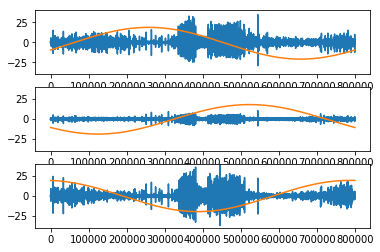

7725 7726 7727


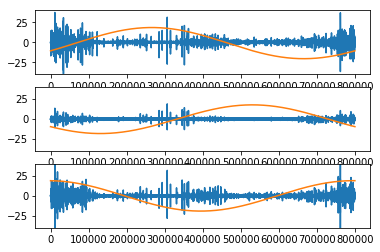

7773 7774 7775


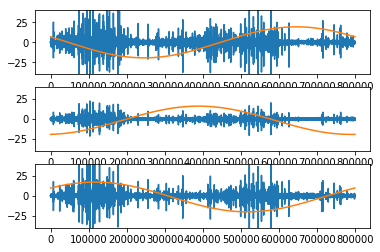

7791 7792 7793


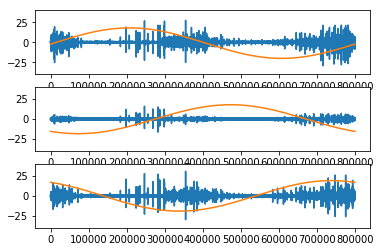

7869 7870 7871


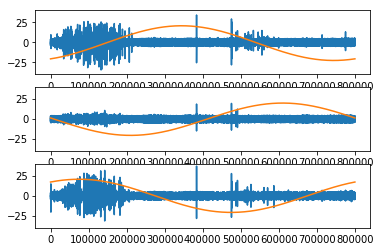

7917 7918 7919


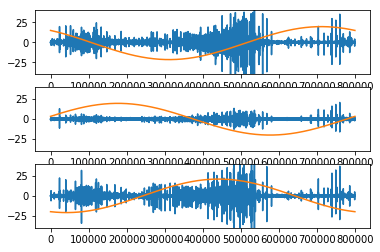

7923 7924 7925


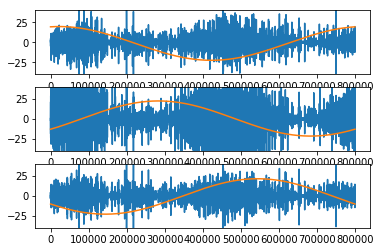

7947 7948 7949


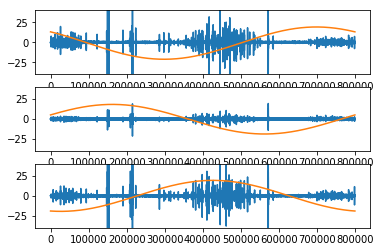

8019 8020 8021


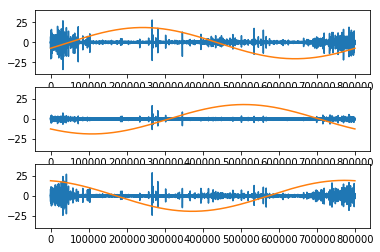

8031 8032 8033


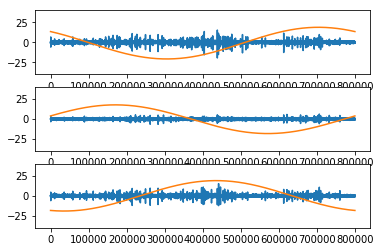

8061 8062 8063


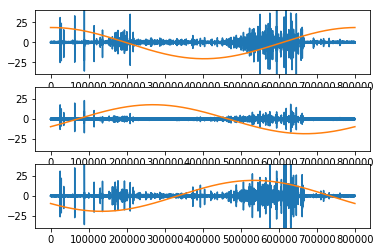

8079 8080 8081


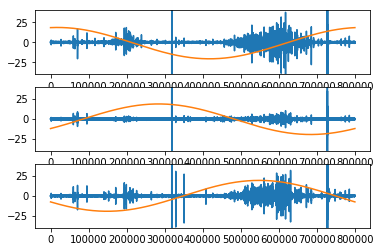

8205 8206 8207


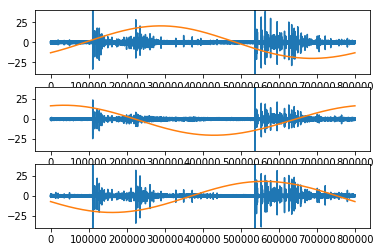

8259 8260 8261


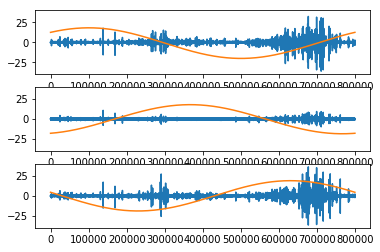

8280 8281 8282


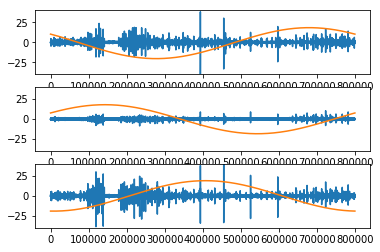

8289 8290 8291


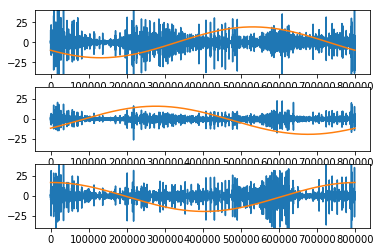

8421 8422 8423


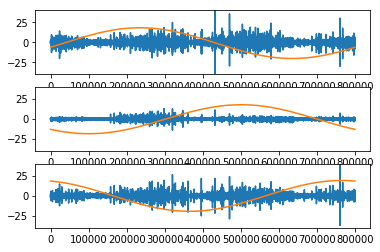

8433 8434 8435


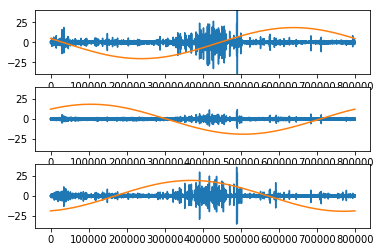

8481 8482 8483


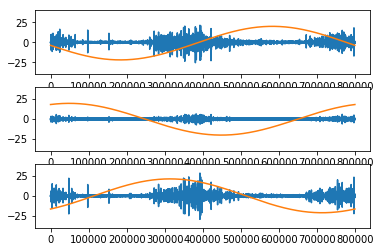

8568 8569 8570


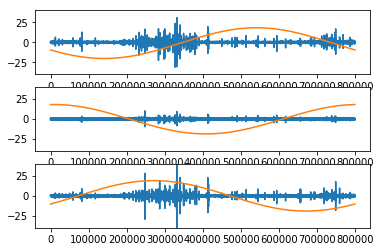

8628 8629 8630


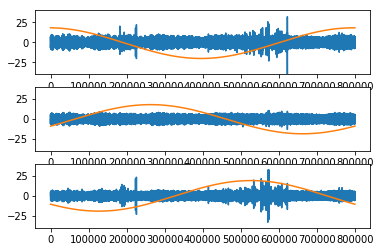

IndexError: list index out of range

In [219]:
plot_n_bads(start=100, n=100)

In [ ]:
plot_n_bads(start=200, n=100)

In [ ]:
plot_n_bads(start=300, n=100)

In [ ]:
plot_n_bads(start=400, n=100)

Why do HF components of phase 1 generally match phase 2, phase 2 generally weaker? (But in very strong PD cases is higher)

In [177]:
#get a new phase set
bthree_phase_sig = train_meta_error_id_measurement[3]
bp1,bp2,bp3 = phase_indices(bthree_phase_sig)

270 271 272


In [178]:
bhf_signal_1 = high_pass(train_set.iloc[:,bp1])
bhf_signal_2 = high_pass(train_set.iloc[:,bp2])
bhf_signal_3 = high_pass(train_set.iloc[:,bp3])

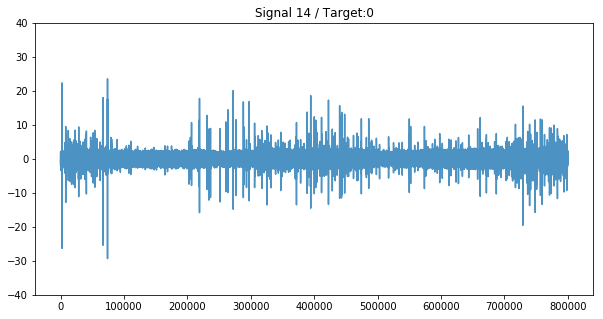

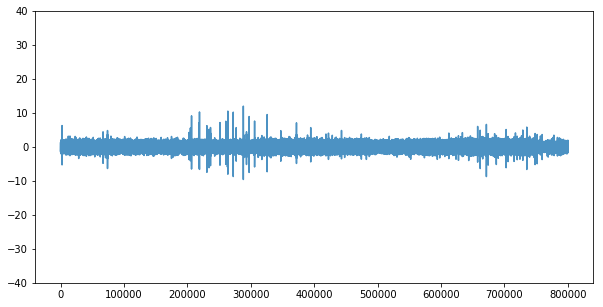

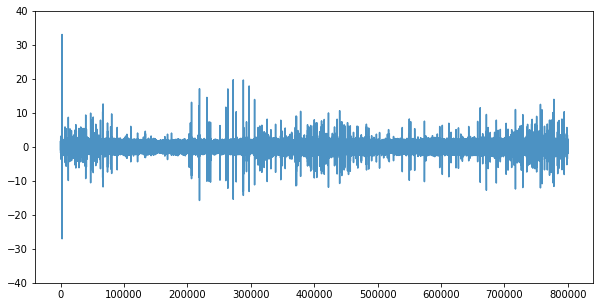

In [179]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(bhf_signal_1, alpha=0.8)
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bhf_signal_2, alpha=0.8)
plt.ylim(-40,40)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bhf_signal_3, alpha=0.8)
plt.ylim(-40,40)
plt.show()

In [175]:
x = sig
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

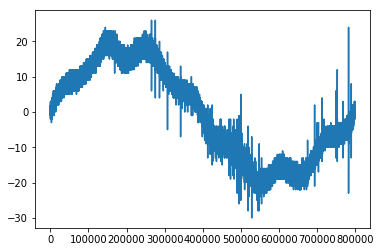

In [24]:
plt.plot(x)

<StemContainer object of 3 artists>

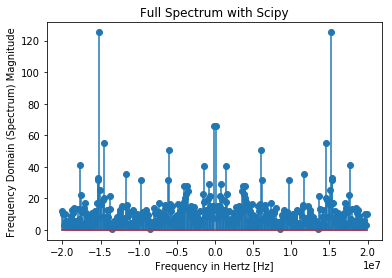

In [11]:
fig, ax = plt.subplots()
ax.set_title('Full Spectrum with Scipy')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [12]:
x = high_pass(train_set.iloc[:,p1])
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

NameError: name 'high_pass' is not defined